In [1]:
import tensorflow as tf

import matplotlib
%matplotlib inline

# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

from imutils import paths
import matplotlib.pyplot as plt
import splitfolders
import numpy as np
import argparse
import pickle
import shutil
import cv2
import os

2024-08-28 16:28:24.465730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 16:28:24.657960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 16:28:24.741482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 16:28:24.772308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 16:28:24.935421: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print('Number of Real Images : {}'.format(len(os.listdir('./dataset/live'))))
print('Number of Spoof Images : {}'.format(len(os.listdir('./dataset/spoof'))))
print('Total Images : {}'.format(
    len(os.listdir('./dataset/live')) + 
    len(os.listdir('./dataset/spoof')) 
    )
)

Number of Real Images : 2100
Number of Spoof Images : 6300
Total Images : 8400


In [3]:
base_dir = './dataset'
data_dir = './dataset/data'

In [6]:
train_dir = os.path.join(data_dir, 'train') ## Train Dataset
validation_dir = os.path.join(data_dir, 'val') ## Validation Dataset
test_dir = os.path.join(data_dir, 'test') ## Test Dataset

In [7]:
train_live_dir = os.path.join(train_dir, 'live')
train_spoof_dir = os.path.join(train_dir, 'spoof')

validation_live_dir = os.path.join(validation_dir, 'live')
validation_spoof_dir = os.path.join(validation_dir, 'spoof')

In [8]:
total_size_train = (
    len(os.listdir(train_live_dir)) + 
    len(os.listdir(train_spoof_dir))
)
print('Total Training Data is : {}'.format(total_size_train))

Total Training Data is : 6300


In [9]:
total_size_validation = (
    len(os.listdir(validation_live_dir)) + 
    len(os.listdir(validation_spoof_dir))
)
print('Total validation data is : {}'.format(total_size_validation))

Total validation data is : 1680


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

adversarial_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 6300 images belonging to 2 classes.
Found 1680 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

In [12]:
# initialize the optimizer and model
print("[INFO] compiling model...")
# opt = Adam(learning_rate=1e-4)
opt = Adam()

[INFO] compiling model...


I0000 00:00:1724884190.508962   18079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724884190.738820   18079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724884190.738933   18079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724884190.745154   18079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724884190.745212   18079 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG19, EfficientNetB4
from tensorflow.keras.models import Sequential

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the feature maps from ResNet50
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dense(2, activation='sigmoid')(x)  # Binary classification output layer

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [15]:
model.compile(
        loss="categorical_crossentropy", 
        optimizer=opt,
    	metrics=["accuracy"]
    )

In [16]:
# train the network
H = model.fit(
        train_generator,
        epochs = 10,
    	validation_data = validation_generator, 
        verbose = 1
	)

[INFO] training network for 10 epochs...
Epoch 1/10


/home/spacheco/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724884197.273852   18257 service.cc:146] XLA service 0x7f14d000f150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724884197.273991   18257 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-28 16:29:57.368806: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 16:29:57.651017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/197 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7109 - loss: 0.5823

I0000 00:00:1724884204.321084   18257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/197 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.8665 - loss: 0.3052

2024-08-28 16:30:19.819532: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_935', 4 bytes spill stores, 4 bytes spill loads

2024-08-28 16:30:19.992102: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_935', 12 bytes spill stores, 12 bytes spill loads

2024-08-28 16:30:21.092244: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 24 bytes spill stores, 24 bytes spill loads

2024-08-28 16:30:21.168737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1320', 32 bytes spill stores, 32 bytes spill loads



197/197 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.8912 - loss: 0.2572 - val_accuracy: 0.9958 - val_loss: 0.0336
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9771 - loss: 0.0668 - val_accuracy: 0.9976 - val_loss: 0.0168
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.9839 - loss: 0.0470 - val_accuracy: 0.9875 - val_loss: 0.0267
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9760 - loss: 0.0614 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.9897 - loss: 0.0293 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9920 - loss: 0.0247 - val_accuracy: 0.9982 - val_loss: 0.0060
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9899 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.9872 - loss: 0.0320 - val

In [23]:
model.save("vgg19_msu_categorical.keras")

In [3]:
import pickle

# Load the training history
with open('./trainHistory', 'rb') as file_pi:
    H = pickle.load(file_pi)

2024-08-30 01:30:40.539927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 01:30:40.557363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 01:30:40.571913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 01:30:40.576045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 01:30:40.590792: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Evaluate the network
scores = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("Evaluate ", model.metrics_names[1], scores[1]*100))

In [9]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(18, 5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'red', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
    
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('Training and Validation Accuracy', fontsize=25)
    plt.legend(bbox_to_anchor=(1, 1), loc='best')
    plt.ylim(0, 1.1)  # Set y-axis limits from 0 to 1
    plt.grid()
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(18, 5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    plt.plot(epochs, loss, 'red', label='Training Loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.title('Training and Validation Loss', fontsize=25)
    plt.legend(bbox_to_anchor=(1, 1), loc='best')
    plt.ylim(0, 1.1)  # Set y-axis limits from 0 to 1
    plt.grid()
    plt.show()


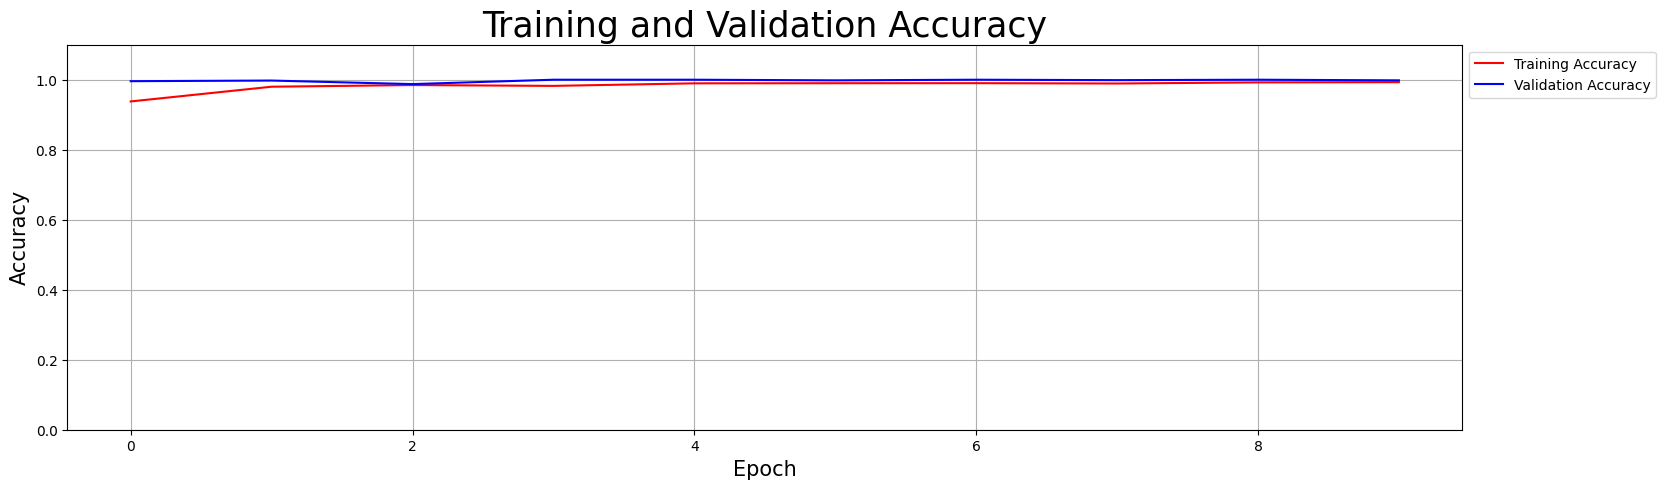

In [10]:
plot_accuracy(H)

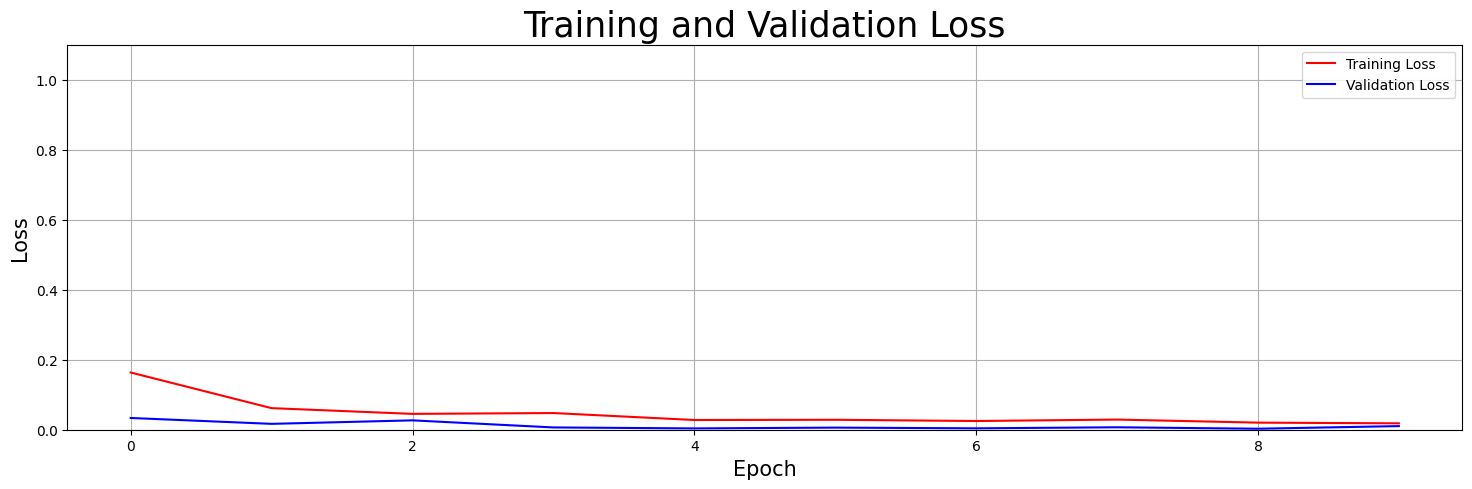

In [11]:
plot_loss(H)